## Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import train_test_split


## Этап 1. Предобработка данных

### Загружаем исходную инфомацию

In [2]:
dbfile = "Данные/shop_database.db"
conn = sqlite3.connect(dbfile)
cursor = conn.cursor()

df_personal_data = pd.read_sql_query('select * \
                                      from personal_data;', conn)

df_personal_data_coeffs = pd.read_sql_query('select * \
                                             from personal_data_coeffs', conn)

df_purchases = pd.read_sql_query('select * \
                                  from purchases', conn)
conn.close()

df_lost = pd.read_csv('Данные/personal_data.csv.gz', compression='gzip', header=0)


display('ID клиентов, их пол, возраст, образование, страна и город проживания', df_personal_data.head(), \
        'Данные с персональными коэффициентами клиентов', df_personal_data_coeffs.head(), \
        'Данные о покупках', df_purchases.head(), \
        'Утерянные данные', df_lost.head())

'ID клиентов, их пол, возраст, образование, страна и город проживания'

,id,gender,age,education,city,country
0,0,0,36,среднее,1201,32
1,4,0,35,среднее,1134,32
2,6,1,52,среднее,1188,32
3,7,0,37,среднее,1198,32
4,9,0,48,среднее,1134,32


'Данные с персональными коэффициентами клиентов'

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072


'Данные о покупках'

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


'Утерянные данные'

,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32


### Объеденим все датафремы в единый датафрейм

In [3]:
# Объединяем датафреймы с данными о клиентах с утерянными данными
df_clients = pd.concat([df_personal_data, df_lost])

# Дополняем датафрейм с клиентами признаком с коэффициентами клиентов
df_clients = df_clients.merge(df_personal_data_coeffs[['id', 'personal_coef']], on='id', how='inner')

df_clients.head()

,id,gender,age,education,city,country,personal_coef
0,0,0.0,36,среднее,1201,32,0.5072
1,4,0.0,35,среднее,1134,32,0.5072
2,6,1.0,52,среднее,1188,32,0.4304
3,7,0.0,37,среднее,1198,32,0.5072
4,9,0.0,48,среднее,1134,32,0.5072


### Исследуем данные

In [4]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104989 entries, 0 to 104988
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   gender         89241 non-null   float64
 2   age            104989 non-null  int64  
 3   education      104989 non-null  object 
 4   city           104989 non-null  int64  
 5   country        104989 non-null  int64  
 6   personal_coef  104989 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 5.6+ MB


#### Оценим правильность данных

На основании информации о типах данных, содержащихся в датаете можно сделат вывод об их соответсвии описываемым показателям.

#### Оценим полноту данных

В признаке `gender` содержаться пропуски. Их количество достаточно велико (15%), поэтому не представляется возможным просто удалить нулевые строки. Необходимо продумать стратегию заполнения пропусков. Предположително можно использовать модель машинного обучения (бинарной классификации) для предсказания пола.

#### Оценим валидность данных

Изучим возраст клиентов на предмет выбросов и аномалий. Построим "ящик с усами" для визуализации распределения значений признака.

<Axes: ylabel='age'>

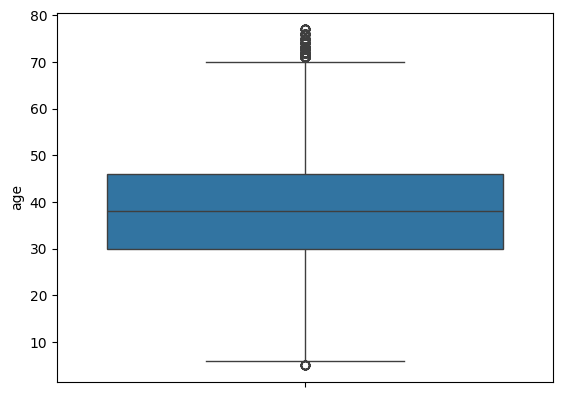

In [5]:
sns.boxplot(df_clients['age'])

Диаграмма показывает, что возраст клиентов находится в пределах от 30 лет до 45 лет. Так же есть данные, которые находятся выше верхней границы распределения возрасов клиентов. Однако, эти данные можно отнести скорее к аномалиям, чем к выбросам, так как они находятся в промежутке от 70 лет до 80 лет, что вполне может быть (пожилые клиенты, ведущие активный образ жизни).  
Изучим персональные коэффициеты клиентов. 

<Axes: ylabel='personal_coef'>

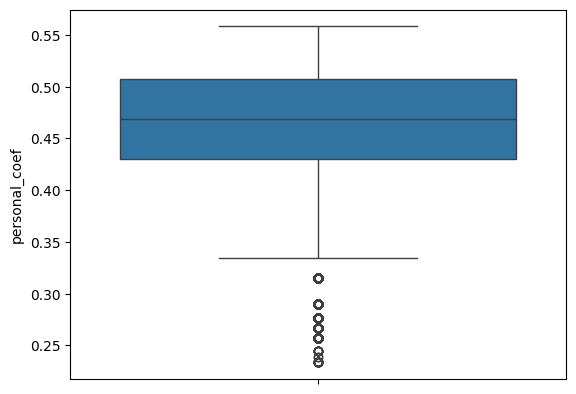

In [6]:
sns.boxplot(df_clients['personal_coef'])

Персональные коэффициенты клиентов находятся в промежутке значений от 0,43 до 0,52, при этом наблюдается значения находящиеся ниже минмальной границы распределения. Эти значения так же можно отнести к аномалиям - данные значения коэффициентов могут быть присвоены клиентам, совершающим покупки на минимальные суммы и не слишком часто.  
В целом, данные в `df_clients` являются валидными. Дополнительых действий не требуется.

### Очистка и заполнение отсутствующих данных в сведениях о клиентах

#### На первом этапе закодируем категориальный признак `education`. Применим алгоритм `LabelEncoder`, так как  между уровнем образования и полом не прослеживается какой-либо значимой иерархческой связи.

In [4]:
le = LabelEncoder()
df_clients['education'] = le.fit_transform(df_clients['education'])

### Обучим несколько моделей бинарной классификации и выберем лучшую.

#### Разобъем данные на тествые и тренировочные данные

In [5]:
df_train = df_clients[~df_clients['gender'].isna()].dropna()
df_test = df_clients[df_clients['gender'].isna()]
x_train = df_train.drop(columns=['gender','id']) 
y_train = df_train['gender']
x_test = df_test.drop(columns=['gender','id']) 
y_test = df_test['gender']

#### Обучаем модели и выбираем лучшую

In [7]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
# подбираем параметры модели
params = {'n_estimators' : [300, 500, 700],
          'max_depth': np.arange(10, 60, 4),
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2)}
rs = RandomizedSearchCV(rfc, params, cv=skf, scoring='f1', n_jobs=-1, error_score='raise') # для выбора параметров испольуем F-меру
rs.fit(x_train, y_train)
print('Скор наилучший: ', rs.best_score_)
print('Лучшие параметры: ', rs.best_params_)

Скор наилучший:  0.9999217894572189
Лучшие параметры:  {'n_estimators': 700, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 34}


In [8]:
params = {"loss":["log_loss", "exponential"],
          "learning_rate": [0.01,0.1,1,10,100],
          'max_depth': np.arange(2, 60, 4),
          'max_features': ['sqrt', 'log2', None],
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2),
          "max_features":["log2","sqrt"],
          "criterion": ["friedman_mse",  "squared_error"],
          "subsample":np.arange(0.1, 1, 0.1),
          "n_estimators":[100, 300, 500]}
rscv = RandomizedSearchCV(gbc, params, cv=skf, scoring='f1', n_jobs=-1, error_score='raise')
rscv.fit(x_train, y_train)
print('Скор наилучший: ', rscv.best_score_)
print('Лучшие параметры: ', rscv.best_params_)

Скор наилучший:  0.9999511141094457
Лучшие параметры:  {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 42, 'loss': 'log_loss', 'learning_rate': 0.1, 'criterion': 'squared_error'}


Построим матрицу ошибок модели для ее оценки

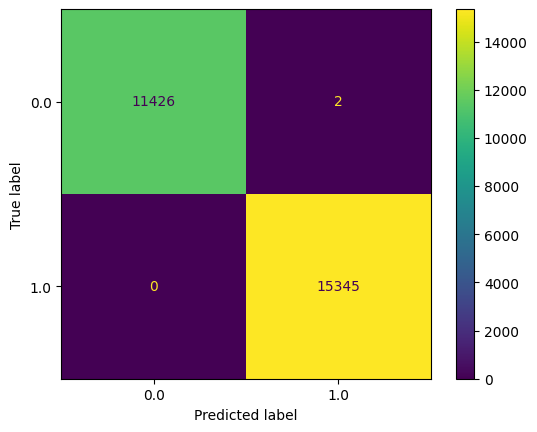

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=82)
gbc_m = GradientBoostingClassifier(subsample=0.7, n_estimators=500, min_samples_split=12, min_samples_leaf=9,
                                   max_features='sqrt', max_depth=54, loss= 'exponential', learning_rate=0.01,
                                   criterion='squared_error').fit(X_train, Y_train)
cnf_matrix = confusion_matrix(Y_test, gbc_m.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                              display_labels=gbc_m.classes_)
disp.plot()
plt.show()

Полученная матрица показывает, что практически все значения классов предсказаны верно. Присутствует всего два случая ложного предсказания.  
Для подверждения полученных результатов построим кривую ROC-AUC.

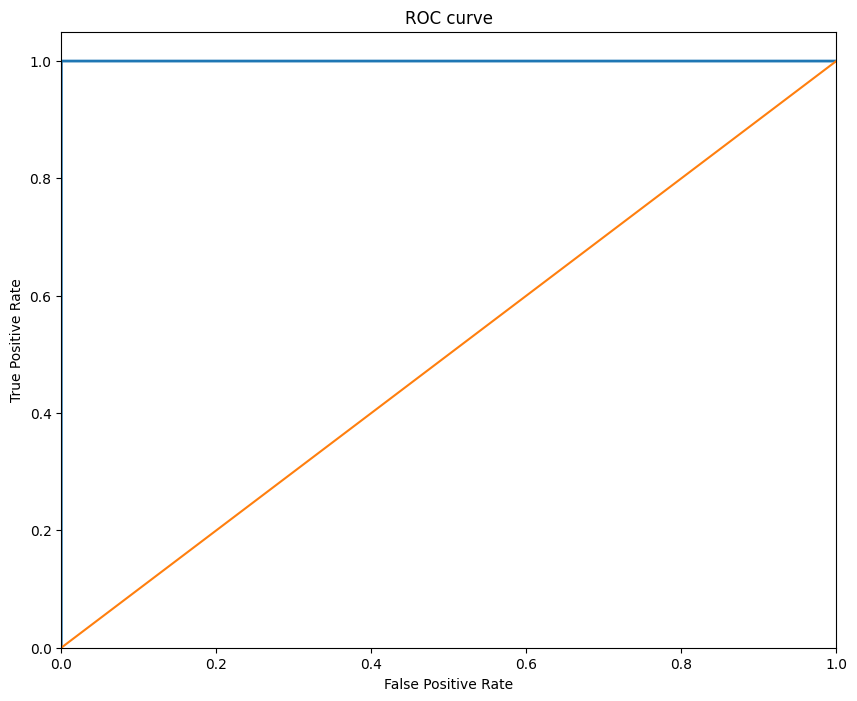

In [10]:
#sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(Y_test, gbc_m.predict_proba(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

Полученная кривая демонстрирует, что все значения предсказаны верно.

#### Наилучшая модель с лучшим скором - это GBC, обучаем модель и предсказываем пол клиента

In [10]:
model = GradientBoostingClassifier(subsample=0.7, n_estimators=500, min_samples_split=12, min_samples_leaf=9,
                                   max_features='sqrt', max_depth=54, loss= 'exponential', learning_rate=0.01,
                                   criterion='squared_error').fit(x_train, y_train)
df_test['gender'] = model.predict(x_test)


C:\Users\V.Nikitin\AppData\Local\Temp\ipykernel_15612\974139726.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['gender'] = model.predict(x_test)


#### Объединяем датафреймы с данными с полом и без пола

In [11]:
df_clients = pd.concat([df_train, df_test])

#### Проверяем, остались ли пропуски

In [39]:
df_clients['gender'].value_counts()

gender
1.0    60072
0.0    44917
Name: count, dtype: int64

### Очистка и заполнение отсутствующих данных в сведениях о покупках

In [41]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           786260 non-null  int64  
 1   product      786260 non-null  object 
 2   colour       666736 non-null  object 
 3   cost         786260 non-null  int64  
 4   product_sex  471548 non-null  float64
 5   base_sale    786260 non-null  int64  
 6   dt           786260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 42.0+ MB


#### Оценим правильность данных

На основании информации о типах данных, содержащихся в датаете можно сделат вывод об их соответсвии описываемым показателям.

#### Оценим полноту данных

В признаке `colour` содержаться пропуски. Их количество достаточно велико (15%), поэтому не представляется возможным просто удалить нулевые строки. Также пропуски содержаться в признаке `product_sex` - пропущено около 40% значений. Так как отсутствующие данные достаточно разнородны по своей природе, то требуется их детальное изучения для определения стратегии заполнения пропусков.

#### Оценим валидность данных

Изучим данные по стоимости, базовой скидке и длительности между покупками на предмет выбросов и аномальности данных.

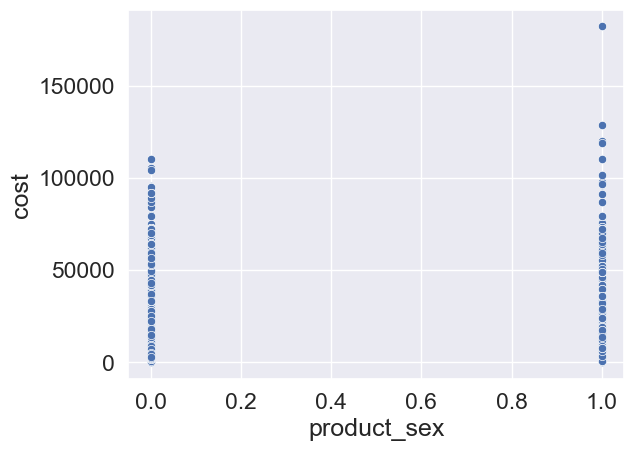

In [51]:
sns.scatterplot(x='product_sex', 
    y='cost', 
    data=df_purchases);

Полченные данные показывают, что выбросов и аномалий в стоимостях товаров нет.

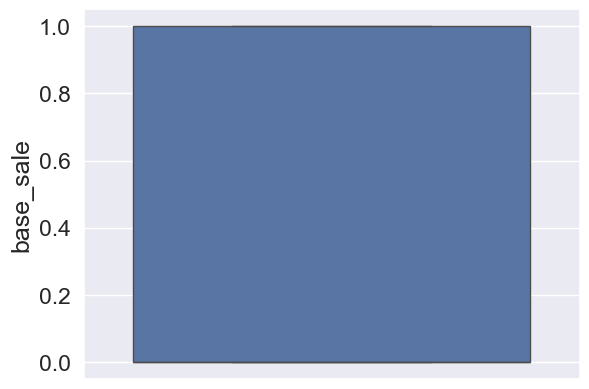

In [53]:
sns.boxplot(df_purchases['base_sale']);

Диаграмма показывает, что все скидки клиентов находятся в пределах от 0% до 100%, что в целом соответствует реальности.

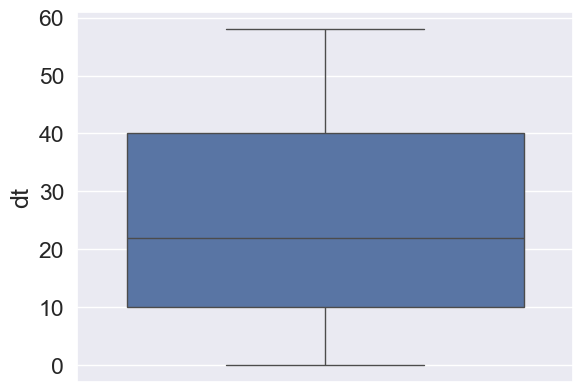

In [54]:
sns.boxplot(df_purchases['dt']);

Из диаграммы видно, что длительность между покупками находится в пределах от 10 дней до 40 дней. Выбросов и аномалий в данном признаке не наблюдается.  
Данные в `df_purchases` являются валидными. Дополнительых действий не требуется.

#### Изучим данные содержащиеся в признаке `colour`.

In [55]:
df_purchases.colour.value_counts()

colour
черный                          131399
белый                            42520
чёрный                           37022
синий                            35268
темно-синий                      27257
                                 ...  
черный/красный/лаймовый              1
желтый/белый/черный                  1
черный/серый/зеленый/голубой         1
белый/золотой/красный                1
черный/циан                          1
Name: count, Length: 1693, dtype: int64

Из представленных данных видно, что количество значений в признаке `colour` достаточно велико - 1693 шт. Вывлены следующие проблемы:  
1. Присутствуют одинаковые по смыслу значения, но с разным написанием. Например, `чёрный` - `черный`. Решение - заменить символ `ё` на  `е`.  
2. Присутствуют значения признаков с несколькими цветами. Например, `черный/красный/лаймовый`. Решение - можно предположить, что первый цвет в описании является доминирующим, поэтому оставляем его. 
3. Присутствуют нулевые значения признака. Решение - так как их количество достаточно велико, заменим их на значение `другой`.  
Выполним указанные действия.

In [12]:
# преобразуем данныые с е и ё
df_purchases['colour'] = df_purchases['colour'].replace(['чёрный'], 'черный')

# отсуттвующий цвет товара заполняем значением 'другой'
df_purchases['colour'] = df_purchases['colour'].fillna('другой')

# оставляем первый цвет в описании товара
df_purchases['colour'] = df_purchases['colour'].apply(lambda x: x.split('/')[0].lower())

In [57]:
df_purchases.colour.value_counts()

colour
черный      210711
другой      119524
белый        67317
синий        51052
серый        40998
             ...  
ht               1
pk               1
hps              1
gsu              1
глиняный         1
Name: count, Length: 315, dtype: int64

После проведенных манипуляций количесво знаений признака `colour` сократилось в 5 раз.

#### Изучим данные содержащиеся в признаке `product_sex`.

In [58]:
df_purchases.product_sex.value_counts()

product_sex
1.0    271433
0.0    200115
Name: count, dtype: int64

Так как нет возможности достоверно определить категорию товара (мужской или женский) из его описания, то введем новое значение признака - унисекс и закодируем его значением 2.

In [13]:
df_purchases['product_sex'] = df_purchases['product_sex'].fillna(2)
df_purchases.product_sex.value_counts()

product_sex
2.0    314712
1.0    271433
0.0    200115
Name: count, dtype: int64

#### Изучим данные содержащиеся в признаке `product`.

In [60]:
df_purchases['product'].value_counts()

product
Брюки мужские Demix                                                                                                                    4961
Шорты мужские Demix                                                                                                                    4650
Футболка мужская Demix                                                                                                                 3644
Лиф женский Joss                                                                                                                       3378
Футболка женская Demix                                                                                                                 3252
                                                                                                                                       ... 
Полуботинки для девочек Salomon SENSE CSWP K                                                                                              1
Аминокислота

Представленные данные показывают, что число значений в признаке достаточно велико - 23145 шт. Можно предположить, что такое количество обусловлено наличием детального описания каждого товара (указание бренда, материала, типаб размера, модели...). Попробуем понизить количество товаров, объеденив их в товарные группы. Для этого оставим в названии товара только русский текст и приедем все к единому регистру.

In [14]:
df_purchases['product'] = df_purchases['product'].apply(lambda x: " ".join(re.findall('[А-Яа-я]{3,20}', x)).lower())

In [62]:
df_purchases['product'].value_counts()

product
кроссовки мужские                           60933
кроссовки женские                           30808
брюки мужские                               24643
футболка мужская                            21858
полуботинки мужские                         21438
                                            ...  
кардиодатчик                                    1
куртка утепленная                               1
шлем красный                                    1
комплект термобелья для мальчиков черный        1
батончик протеиновый                            1
Name: count, Length: 3610, dtype: int64

В результате удалось снизить количество значений признака с 23145 шт. до 3610 шт. - более чем в 6 раз.

## Этап 2. Проведение А/В-тестирования для оценки эффективности маркетинговой компании.

Для проведения A/B-тестирования в качестве метрик для оценки эффективности маркетинговой компании предлагается испольовать следующие метрики:  
  
  
1. Средняя выручка на одного покупателя  
    <b>Выдвигаемые гипотезы:</b>  
        Нулевая гипотеза: После проведения маркетинговой компании среняя выручка на одного покуптеля в тестовой группе изменилась незначительно (нет статистической значмости).  
        Альтернативная гепотиза: После проведения маркетинговой компании среняя выручка на одного покуптеля в тестовой группе значительно изменилась (есть статистическая значмость). 


2. Средний чек покупателя  
    <b>Выдвигаемые гипотезы:</b>  
        Нулевая гипотеза: После проведения маркетинговой компании сумма среднего чека на одного покуптеля в тестовой группе изменилась незначительно (нет статистической значмости).  
        Альтернативная гепотиза: После проведения маркетинговой компании сумма среднего чека на одного покуптеля в тестовой группе значительно изменилась (есть статистическая значмость).
          
          
3. Срелнее количество покупок  
    <b>Выдвигаемые гипотезы:</b>  
        Нулевая гипотеза: После проведения маркетинговой компании сренее количество покупок одного покуптеля в тестовой группе изменилась незначительно (нет статистической значмости).  
        Альтернативная гепотиза: После проведения маркетинговой компании сренее количество покупок одного покуптеля в тестовой группе значительно изменилась (есть статистическая значмость).

#### Загружаем файлы с информацией о тестовой и контрольной группах

In [15]:
with open('Данные/ids_first_company_positive.txt') as f:
    positive = f.read()
elem_list = re.split(';|,| ', positive)
positive_id = []
for i in elem_list:
    if i.isdigit():
        positive_id.append(int(i))
with open('Данные/ids_first_company_negative.txt') as f:
    negative = f.read()
elem_list = re.split(';|,| ', negative)
negative_id = []
for i in elem_list:
    if i.isdigit():
        negative_id.append(int(i))

# В тестовую группу берем покупки которые были совершены во время проведения первой рекламной компании
df_test = df_purchases[(df_purchases['dt'] >= 5) & (df_purchases['dt'] < 17)]

# Получаем значение выручки на одного клиента
arpu_group1 = df_test.groupby('id', as_index=False).agg({'cost':'sum'})

# Создаем датафрейм с клиентами со скидками по рекламной компании
positive_arpu = arpu_group1.loc[arpu_group1['id'].isin(positive_id), :]

# Создаем датафрейм с клиентами без скидок
negative_arpu = arpu_group1.loc[arpu_group1['id'].isin(negative_id), :]

#### Проверим выборки на нормальность распределения с помощью теста Шапиро-Уилка при р-значении=0.05

In [16]:
if stats.shapiro(positive_arpu['cost'])[1] < 0.05:
    print('Так как полученное р-значение меньше выбранного порогового, то гипотезу о нормальности распредления данных в тетовой выборке можно отклонить. Данные распределены ненормально.')
else:
    print('Так как полученное р-значение больше выбранного порогового, то гипотезу о нормальности распредления данных в тестовой выборке можно принять. Даные распределены нормально.')    

Так как полученное р-значение меньше выбранного порогового, то гипотезу о нормальности распредления данных в тетовой выборке можно отклонить. Данные распределены ненормально.


In [17]:
if stats.shapiro(negative_arpu['cost'])[1] < 0.05:
    print('Так как полученное р-значение меньше выбранного порогового, то гипотезу о нормальности распредления данных в контрольной выборке можно отклонить. Данные распределены ненормально.')
else:
    print('Так как полученное р-значение больше выбранного порогового, то гипотезу о нормальности распредления данных в контрольной выборке можно принять. Даные распределены нормально.')   

Так как полученное р-значение меньше выбранного порогового, то гипотезу о нормальности распредления данных в контрольной выборке можно отклонить. Данные распределены ненормально.


#### Так как распределение в выборках отличается от нормального, а выборки являются независимыми (разделение произошло случайным образом), то для проверки выдвинутых гипотез будем использовать критерий `Манна-Уитни`.

##### Проверим гипотезу о средней выручке на одного покупателя

In [18]:
mann = stats.mannwhitneyu(positive_arpu['cost'], negative_arpu['cost'])

if mann[1] < 0.05:
    print('Наблюдается статистически значимая разница в средней выручке на покупателя в тестовой и контрольной группе')
else:
    print('Статистически значимой разницы в средней выручке на покупателя в тестовой и контрольной группе нет')

Наблюдается статистически значимая разница в средней выручке на покупателя в тестовой и контрольной группе


##### Визуализируем результат проверки гипотезы о средней выручке на клиента

C:\Users\V.Nikitin\AppData\Local\Temp\ipykernel_15612\1840516331.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ['Тестовая группа', 'Контрольная группа'], y = [positive_arpu['cost'].mean(),


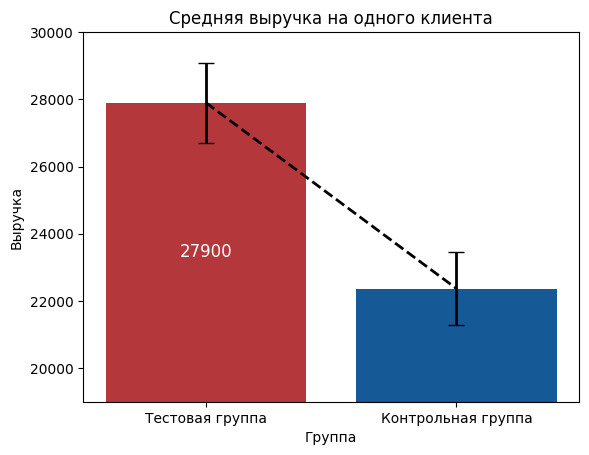

In [19]:
std_error_test= np.std(positive_arpu['cost']) / np.sqrt(len(positive_arpu['cost']))
std_error_control = np.std(negative_arpu['cost']) / np.sqrt(len(negative_arpu['cost']))
fig,ax = plt.subplots()
sns.barplot(x = ['Тестовая группа', 'Контрольная группа'], y = [positive_arpu['cost'].mean(),
                                                  negative_arpu['cost'].mean()],
                                                  palette=['#C92228','#005AAB'], legend=False)
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.0f')
ax.set_title('Средняя выручка на одного клиента')
ax.set(xlabel='Группа', ylabel='Выручка',  ylim=(19000, 30000))
ax.errorbar(x = ['Тестовая группа', 'Контрольная группа'], y = [positive_arpu['cost'].mean(),
                                                  negative_arpu['cost'].mean()],
                                                  yerr = [1.96*std_error_test, 1.96*std_error_control],
                                                  fmt='--k', linewidth=2, capsize=6, ecolor= 'black');

##### Проверим гипотезу о среднем чеке.  
Расчитаем средний чек клиента в тестовой и контрольной группе 

In [20]:
bill_group = df_test.groupby(['dt','id'], as_index=False).agg({'cost':'sum'})
positive_bill = bill_group.loc[bill_group['id'].isin(positive_id), :]
negative_bill = bill_group.loc[bill_group['id'].isin(negative_id), :]

In [21]:
mann = stats.mannwhitneyu(positive_bill['cost'], negative_bill['cost'])

if mann[1] < 0.05:
    print('Наблюдается статистически значимая разница в среднем чеке покупателя в тестовой и контрольной группе')
else:
    print('Статистически значимой разницы в среднем чеке покупателя в тестовой и контрольной группе нет')

Наблюдается статистически значимая разница в среднем чеке покупателя в тестовой и контрольной группе


##### Визуализируем результат проверки гипотезы о среднем чеке клиента

C:\Users\V.Nikitin\AppData\Local\Temp\ipykernel_15612\1145137760.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ['Тестовая группа', 'Контрольная группа'], y = [positive_bill['cost'].mean(),


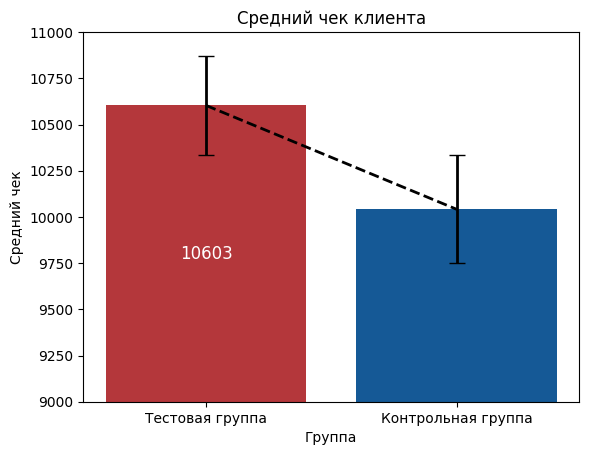

In [22]:
std_error_test= np.std(positive_bill['cost']) / np.sqrt(len(positive_bill['cost']))
std_error_control = np.std(negative_bill['cost']) / np.sqrt(len(negative_bill['cost']))

fig,ax = plt.subplots()
sns.barplot(x = ['Тестовая группа', 'Контрольная группа'], y = [positive_bill['cost'].mean(),
                                                  negative_bill['cost'].mean()],
                                                  palette=['#C92228','#005AAB'], legend=False)
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.0f')
ax.set_title('Средний чек клиента')
ax.set(xlabel='Группа', ylabel='Средний чек', ylim=(9000, 11000))
ax.errorbar(x = ['Тестовая группа', 'Контрольная группа'], y = [positive_bill['cost'].mean(),
                                                  negative_bill['cost'].mean()],
                                                  yerr = [1.96*std_error_test, 1.96*std_error_control],
                                                  fmt='--k', linewidth=2, capsize=6, ecolor= 'black');

##### Проверим гипотезу о среднем количестве покупок клиента.  
Проведем группировку данных по количеству покупок на 1 клиента

In [23]:
count_group = df_test.groupby(['id'], as_index=False).agg({'cost':'count'})
positive_сount = count_group.loc[count_group['id'].isin(positive_id), :]
negative_сount = count_group.loc[count_group['id'].isin(negative_id), :]

In [24]:
mann = stats.mannwhitneyu(positive_сount['cost'], negative_сount['cost'])

if mann[1] < 0.05:
    print('Наблюдается статистически значимая разница в количестве покупок в тестовой и контрольной группе')
else:
    print('Статистически значимой разницы в количестве покупок в тестовой и контрольной группе нет')

Наблюдается статистически значимая разница в количестве покупок в тестовой и контрольной группе


##### Визуализируем результат проверки гипотезы о количесте покупок клиента

C:\Users\V.Nikitin\AppData\Local\Temp\ipykernel_15612\928231810.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = ['Тестовая группа', 'Контрольная группа'], y = [positive_сount['cost'].mean(),


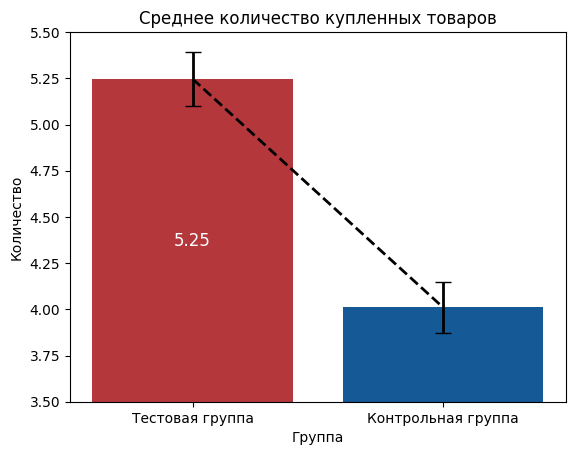

In [25]:
std_error_test= np.std(positive_сount['cost']) / np.sqrt(len(positive_сount['cost']))
std_error_control = np.std(negative_сount['cost']) / np.sqrt(len(negative_сount['cost']))

fig,ax = plt.subplots()
sns.barplot(x = ['Тестовая группа', 'Контрольная группа'], y = [positive_сount['cost'].mean(),
                                                  negative_сount['cost'].mean()],
                                                  palette=['#C92228','#005AAB'])
ax.bar_label(ax.containers[0], fontsize=12, label_type='center', color='white', fmt='%.2f')
ax.set_title('Среднее количество купленных товаров')
ax.set(xlabel='Группа', ylabel='Количество', ylim=(3.5, 5.5))

ax.errorbar(x = ['Тестовая группа', 'Контрольная группа'], y = [positive_сount['cost'].mean(),
                                                  negative_сount['cost'].mean()],
                                                  yerr = [1.96*std_error_test, 1.96*std_error_control],
                                                  fmt='--k', linewidth=2, capsize=6, ecolor= 'black');

#### Выводы по проведенному А/В-тестированию.  
По результатам проведения тестирвания выявлена статистически значимая разница во всех трех метриках в расчете на одного клиента, выбранных для оценки эффективности маркетинговой компании:  
- средняя выручка в тестовой группе выше на 25%;  
- средний чек выше на 6%;  
- среднее количество купленных товаров выше на 31%.  

 <b>Вывод</b> - маркетинговая компания эффективна.  
 <b>Рекомендации</b> - продолжать данную маркетинговую компанию.

## Этап 3. Кластеризация клиентов

### Создаем агрегированный фрейм данных для проведения кластеризации

In [26]:
df_group = df_purchases.groupby('id', as_index=False).agg({'cost':'sum',
                                                   'product': pd.Series.mode,
                                                   'colour': pd.Series.mode,
                                                   'product_sex': pd.Series.mode,
                                                   'base_sale':'mean',
                                                   'dt':'max'
                                                   })
# Переименовываем признаки согласно смысловому наполнению
dict = {'cost': 'cost_sum',
        'product': 'product_mode',
        'colour': 'color_mode',
        'product_sex': 'product_sex_mode',
        'base_sale': 'best_sale_mean',
        'dt': 'dt_max'}
df_group = df_group.rename(columns=dict)

### Проводим предобработку данных

In [27]:
mode_columns = ['product_mode', 'color_mode', 'product_sex_mode']

for column in mode_columns:
    df_group[column] = df_group[column].apply(lambda x: x[0] if type(x) == np.ndarray else x)

# Объединяем датафрейм с клиентским клиентах
df = pd.merge(left=df_clients, right=df_group, on='id', how='inner')

# Удалим поле, которое не являются значимым
df = df.drop(columns=['id'])

### Проведем стандартизацю данных

In [28]:
num_columns = ['age', 'personal_coef','cost_sum', 'best_sale_mean','dt_max']
scaler = StandardScaler()
df[num_columns] = scaler.fit_transform(df[num_columns])


In [29]:
df

,gender,age,education,city,country,personal_coef,cost_sum,product_mode,color_mode,product_sex_mode,best_sale_mean,dt_max
0,0.0,-0.164185,1,1201,32,0.780515,-0.273267,велосипед горный женский,бежевый,2.0,0.018147,-0.263520
1,0.0,-0.245598,1,1134,32,0.780515,-0.124694,роликовые коньки детские,белый,2.0,-1.196488,-0.610717
2,1.0,1.138417,1,1188,32,-0.446917,0.578515,кроссовки мужские,черный,1.0,0.261074,-0.749595
3,0.0,-0.082773,1,1198,32,0.780515,0.243339,бутсы для мальчиков,красный,2.0,0.205014,0.569751
4,0.0,0.812766,1,1134,32,0.780515,0.302563,ветровка женская,милитари,0.0,2.083027,1.055825
...,...,...,...,...,...,...,...,...,...,...,...,...
104984,1.0,0.487116,1,1134,32,-0.446917,0.156512,ботинки женские,серый,0.0,0.018147,1.125265
104985,1.0,0.649941,1,1134,32,-0.446917,-0.254994,кроссовки женские,другой,1.0,-1.196488,0.847508
104986,0.0,2.685256,1,1134,32,0.780515,-0.368440,брюки мужские,черный,0.0,0.261074,-1.027352
104987,1.0,-0.489836,1,1188,32,-0.446917,1.035139,кроссовки мужские,черный,1.0,-0.467707,-1.235670


In [ ]:
n_clusters = list(range(2,8))
cost = []
for n in n_clusters:
    kproto = KPrototypes(n_clusters=n, init='Cao', n_jobs=-1)
    kproto.fit_predict(df.iloc[:5000], categorical=[0,2,3,4,7,8,9])
    cost.append(kproto.cost_)

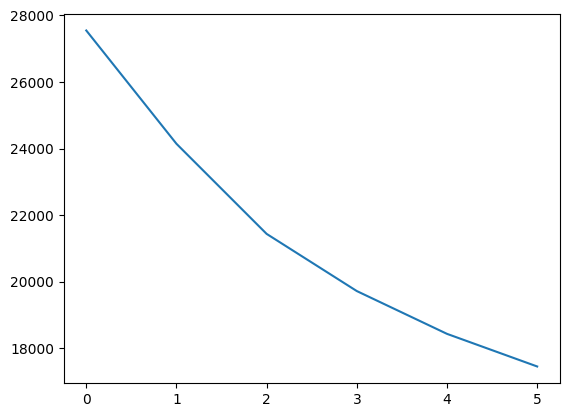

In [144]:
sns.lineplot(cost);

#### Количество кластеров примем равное 4.

#### Удаляем ненужные признаки

In [31]:
df = df.drop(["color_mode", "product_mode"], axis=1)

#### Проводим обучение модели кластеризации с принятыми параметрами

In [32]:
kproto = KPrototypes(n_clusters=4, init='Cao', n_jobs=-1)
kproto.fit_predict(df, categorical=[0,2,3,4])

array([1, 1, 1, ..., 2, 1, 0], dtype=uint16)

#### Понижаем размерность данных для дальнейшей визуализации

In [ ]:
tsne = TSNE(n_components=3, perplexity=40)
df_emb = tsne.fit_transform(df[num_columns])
data = pd.DataFrame(df_emb)

##### Строим диаграмму рассеевания кластеров

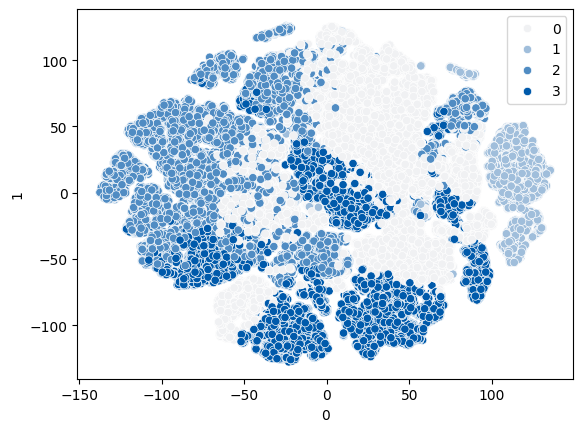

In [147]:
pallete = sns.color_palette("light:#005AAB", as_cmap=True)
sns.scatterplot(x=data[0], y=data[1], hue=kproto.labels_, palette=pallete);

#### Преобразуем данные для интерпритации результата

In [34]:
df[num_columns] = scaler.inverse_transform(df[num_columns])
num_columns.extend(['education','gender'])
mode_cols = set(df.columns) - set(num_columns)
d1 = dict.fromkeys(num_columns, 'mean')
d2 = dict.fromkeys(mode_cols, pd.Series.mode)

In [35]:
d = {**d1, **d2}
df_g1 = df.groupby(kproto.labels_, as_index=False).agg(d)
df_g1 = df_g1.round(2).T
df_g1 = df_g1.rename(columns={0:'cluster 1', 1:'cluster 2', 2:'cluster 3', 3:'cluster 4'})
df_g1

C:\Users\V.Nikitin\AppData\Local\Temp\ipykernel_15612\4213953957.py:2: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  df_g1 = df.groupby(kproto.labels_, as_index=False).agg(d)


,cluster 1,cluster 2,cluster 3,cluster 4
age,39.78,38.61,39.97,15.81
personal_coef,0.46,0.47,0.49,0.27
cost_sum,60572.66,25731.69,28715.41,37975.49
best_sale_mean,0.22,0.17,0.60,0.33
dt_max,50.30,23.23,44.19,39.46
education,0.84,0.80,0.82,0.20
gender,0.75,0.63,0.28,0.68
city,1134.00,1134.00,1134.00,1134.00
product_sex_mode,2.00,1.00,0.00,1.00
country,32.00,32.00,32.00,32.00


## Результаты исследования:  
В результате проведения исследования клиентской базы было выявленно 4 кластера. Профили полученных кластеров можно охарактеризовать следующим образом:  
1.	Первый кластер - это люди в возрасте около 40 лет, в основном мужчины (75%), имеющие среднее образованиее (16%), в 22% случаев приобретают товары со скидкой, готовы тратить в среднем 60,5 тысяч рублей и совершающие покупки один раз в полтора месяца (50 дней между поупками).  
2.	Второй кластер -  в основном мужчины (63%), имеют среднее образование (20%), приобретают товары по скидкам 17%, средние расходы на пкупки составлют 25,7 тысячи рублей, возратная категория - 38+ лет.  
3.	Третий кластер - это люди в  возрасте до 40 лет, совершающие пкупки в среднем раз в 44 дня, 18% из них имеет среднее образование, средние расходы составляют 28,7 тысячи рублей и в 40% случаев клиенты данной группы пиобретают товары по полной стоимости.  
4.	Четвертый кластер - это молодежь (средний возраст 16 лет), и имеют в основном высшее образование (80%). В основном мужчины (68%), треть покупок совершают со скидкой. Средняя сумма покупок составляет 37,9 тысяч рублей. В среднем покупки совершают раз в 40 дней.

## Этап 4. Модель склонности клиента к покупке товара

### Загружаем необходимые данные

In [78]:
with open('Данные/ids_first_company_positive.txt') as f:
    positive = f.read()
elem_list = re.split(';|,| ', positive)
positive_id = []
for i in elem_list:
    if i.isdigit():
        positive_id.append(int(i))


### Строим выборку клиентов, принимавших участие в первой маркетингвой компании

In [79]:
df_first = df_purchases[(df_purchases['dt'] >= 5) & (df_purchases['dt'] < 17)]
product_group = df_first.groupby('id', as_index=False).agg({'product': pd.Series.mode})
first_camp = product_group.loc[product_group['id'].isin(positive_id), :]
first_camp['product'] = first_camp['product'].apply(lambda x: x[0] if type(x) == np.ndarray else x)


C:\Users\V.Nikitin\AppData\Local\Temp\ipykernel_2916\1362654131.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_camp['product'] = first_camp['product'].apply(lambda x: x[0] if type(x) == np.ndarray else x)


### Строим выборку клиентов, принимавших участие во второй маркетингвой компании

In [80]:
df_second = df_purchases[(df_purchases['dt'] == 15) | (df_purchases['dt'] == 45)]
second_camp = df_second.groupby('id', as_index=False).agg({'product': pd.Series.mode})
second_camp['product'] = second_camp['product'].apply(lambda x: x[0] if type(x) == np.ndarray else x)


### Объеденяем данные в единый датафрейм

In [81]:
# объединяем датафреймы по покупкам и первой маркетинговой компании
first_df = pd.merge(left=df_clients, right = first_camp, on='id', how='inner')
second_df = pd.merge(left=df_clients, right = second_camp, on='id', how='inner')
second_df = second_df[second_df.city == 1134]

### Выполним предобработку данных

In [82]:
train = first_df.merge(second_df)
train.drop_duplicates() 
train['product'] = train['product'].apply(lambda x: x.split(' ')[0])


### Создаем тестовый датафрейм для проверки предпочтений жителей страны 32 города 1 188.

In [83]:
test = df_clients[(df_clients.city == 1188) & (df_clients.country == 32)]

### Обучаем и выбираем лучшую модель

In [84]:
x_train = train.drop(columns=['id', 'product'])
y_train = train['product']
x_test = test.drop(columns=['id'])
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rfc = RandomForestClassifier()

params = {'n_estimators' : [300, 500, 700],
          'max_depth': np.arange(10, 60, 4),
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 2),
          'class_weight': ('balanced', None)}
rs = RandomizedSearchCV(rfc, params, cv=skf, scoring='f1_micro', n_jobs=-1, error_score='raise') # по F-мере
rs.fit(x_train, y_train)
print('Лучший скор: ', rs.best_score_)
print('Лучшие параметры: ', rs.best_params_)

c:\Users\V.Nikitin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Лучший скор:  0.11192639180060564
Лучшие параметры:  {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_depth': 46, 'class_weight': None}


### Обучим лучшую модель на полном наборе данных

In [85]:
model = RandomForestClassifier(n_estimators=500, min_samples_split=10, min_samples_leaf=7, max_depth=18, class_weight=None)
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=18, min_samples_leaf=7, min_samples_split=10,
                       n_estimators=500)

### Применим модель для определения склонноски клиента к покупке товара.

In [86]:
model_pred = model.predict(x_test)
x_test['product'] = model_pred
x_test['product'].value_counts()

product
кроссовки    11426
кеды           512
бейсболка      378
брюки          122
Name: count, dtype: int64

# Результат:
С помощью полученной модели на обучающей выборке был проведен поиск склонности клиентов по покупке определенных товаров. После применения модели на тестовой выборке были получены следующие результаты по стране 32 городу 1188:  
- в большей степени жители данного региона склнны к покупке кросовок;  
- примерно одинаковая склонность у жителей региона к приобретению кед и бейсболок.
- не часто клиенты готовы приобретать брюки.